# Automated Capsnets train + test

First, import stuff

In [5]:
import model
import data_loader
import tensorflow as tf

In [6]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [15]:
# WORD_VEC_SCENARIO = "FastText-300-datasets-synAntVSP"
WORD_VEC_SCENARIO = 'FastText-300-nocounterfit'

word2vec_path = '../../romanian_word_vecs/cc.ro.300.vec'

# No diacritics data
training_data_paths = [
        '../data-capsnets/scenario0/train.txt',
        '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
#         '../data-capsnets/diacritics/scenario0/train.txt',
#         '../data-capsnets/diacritics/scenario1/train.txt',
#         '../data-capsnets/diacritics/scenario2/train.txt',
#         '../data-capsnets/diacritics/scenario31/train.txt',
#         '../data-capsnets/diacritics/scenario32/train.txt',
#         '../data-capsnets/diacritics/scenario33/train.txt',
        
    ]
test_data_paths = [
    '../data-capsnets/scenario0/test.txt',
    '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
#     '../data-capsnets/diacritics/scenario0/test.txt',
#     '../data-capsnets/diacritics/scenario1/test.txt',
#     '../data-capsnets/diacritics/scenario2/test.txt',
#     '../data-capsnets/diacritics/scenario31/test.txt',
#     '../data-capsnets/diacritics/scenario32/test.txt',
#     '../data-capsnets/diacritics/scenario33/test.txt',
]

scenario_nums = [
    '0_' + WORD_VEC_SCENARIO,
    '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
#     '0_dia_' + WORD_VEC_SCENARIO,
#     '1_dia_' + WORD_VEC_SCENARIO,
#     '2_dia_' + WORD_VEC_SCENARIO,
#     '31_dia_' + WORD_VEC_SCENARIO,
#     '32_dia_' + WORD_VEC_SCENARIO,
#     '33_dia_' + WORD_VEC_SCENARIO,
]

In [8]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
------------------load word2vec end---------------------


# Flag setting functions + utils

In [9]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 64

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 16, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 20, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 5, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results_{}.csv'.format(WORD_VEC_SCENARIO), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [16]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
------------------read datasets end---------------------
TRAINING 0_FastText-300-nocounterfit
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.076923
F score 0.076923
Slot filling
F1 score: 0.014426
Accuracy: 0.013504
------------------epoch :  0  Loss:  17.560093 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.464103
F score 0.464103
Slot filling
F1 score: 0.367568
Accuracy: 0.916752
Current F score mean 0.4158350658350659
Best F score mean 0.4158350658350659
------------------epoch :  1  Loss:  7.328554 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.751282
F score 0.751282
Slot filling
F1 score: 0.672269
Accuracy

------------------epoch :  5  Loss:  0.21704051 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994872
F score 0.994872
Slot filling
F1 score: 0.976431
Accuracy: 0.997436
Current F score mean 0.9856513856513855
Best F score mean 0.9856513856513855
------------------epoch :  6  Loss:  0.17509079 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994872
F score 0.994872
Slot filling
F1 score: 0.978676
Accuracy: 0.997607
Current F score mean 0.9867737201070534
Best F score mean 0.9867737201070534
------------------epoch :  7  Loss:  0.14819711 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994872
F score 0.994872
Slot filling
F1 score: 0.982022
Accuracy: 0.998120
Current F score mean 0.9884471333909537
Best F score mean 0.9884471333909537
------------------epoch :  8  Loss:  0.12802133 ----------------------
           VALIDA

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.995475
Accuracy: 0.999487
Current F score mean 0.997737556561086
Best F score mean 0.997737556561086
------------------epoch :  12  Loss:  0.12926023 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.995475
Accuracy: 0.999487
Current F score mean 0.997737556561086
Best F score mean 0.997737556561086
------------------epoch :  13  Loss:  0.118793346 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.995475
Accuracy: 0.999487
Current F score mean 0.997737556561086
Best F score mean 0.997737556561086
------------------epoch :  14  Loss:  0.109847546 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F

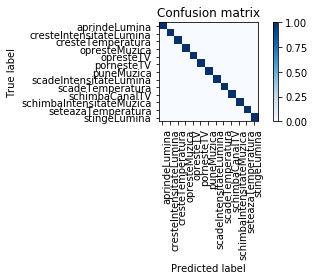

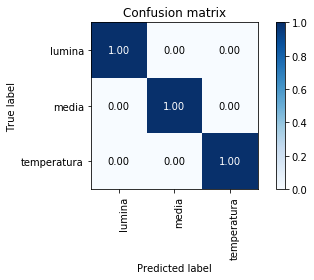

Intent F1: 1.000000
Slot F1: 0.995475
------------------read datasets begin-------------------
------------------read datasets end---------------------
TRAINING 1_FastText-300-nocounterfit
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.135294
F score 0.135294
Slot filling
F1 score: 0.004761
Accuracy: 0.016742
------------------epoch :  0  Loss:  12.460771 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.497059
F score 0.497059
Slot filling
F1 score: 0.404591
Accuracy: 0.908371
Current F score mean 0.45082496413199424
Best F score mean 0.45082496413199424
------------------epoch :  1  Loss:  6.23308 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.917647
F score 0.917647
S

------------------epoch :  5  Loss:  0.18429571 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.993039
Accuracy: 0.999548
Current F score mean 0.9965197215777262
Best F score mean 0.9965197215777262
------------------epoch :  6  Loss:  0.105049126 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.993039
Accuracy: 0.999548
Current F score mean 0.9965197215777262
Best F score mean 0.9965197215777262
------------------epoch :  7  Loss:  0.08824824 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.993039
Accuracy: 0.999548
Current F score mean 0.9965197215777262
Best F score mean 0.9965197215777262
------------------epoch :  8  Loss:  0.076634236 ----------------------
           VALI

------------------epoch :  13  Loss:  0.04923624 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997041
F score 0.997041
Slot filling
F1 score: 0.997706
Accuracy: 0.999545
Current F score mean 0.9973739210683459
Best F score mean 1.0
------------------epoch :  14  Loss:  0.04577831 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997041
F score 0.997041
Slot filling
F1 score: 0.997706
Accuracy: 0.999545
Current F score mean 0.9973739210683459
Best F score mean 1.0
------------------epoch :  15  Loss:  0.04280614 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997041
F score 0.997041
Slot filling
F1 score: 0.997706
Accuracy: 0.999545
Current F score mean 0.9973739210683459
Best F score mean 1.0
------------------epoch :  16  Loss:  0.040222503 ----------------------
           VALIDATION SET PERFORMANCE        
Intent dete

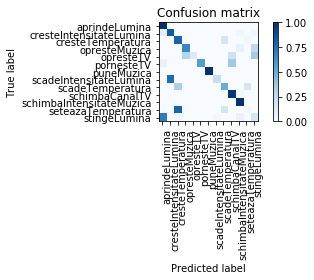

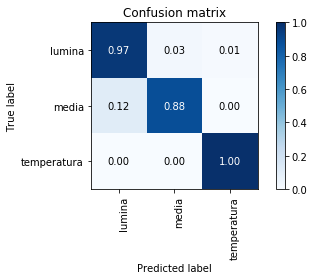

Intent F1: 0.607692
Slot F1: 0.802260


In [17]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(data, FLAGS, batches_rand=False)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)



